# MLP from Scratch

Kishore GV EE16B070

Coded up a MLP Classifier from scratch using no DL libraries(Just numpy and matplotlib). Used Scikit-learn to visualize results of the classifier on MNIST dataset. Also, compared the results obtained with ML techniques like SVM and k-NN.  

Importing necessary libraries

In [20]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.svm import LinearSVC

Function to get intervals for weight initialization

In [21]:
def glorot_num(in_layer_dim,out_layer_dim):
    return np.sqrt(6.0/(in_layer_dim+out_layer_dim))

In [22]:
def softmax(x):
    return np.exp(x-np.max(x,axis=0))/(np.sum(np.exp(x-np.max(x,axis=0)),axis=0))

In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [24]:
def relu(x):
    return  x * (x >= 0)# & (x<=1)) +  1 *( x>= 5)

In [25]:
def activate(x,activation):
    if(activation=='sigmoid'):
        return sigmoid(x)
    if(activation=='linear'):
        return x
    if(activation=='relu'):
        return relu(x)
    if(activation=='tanh'):
        return np.tanh(x)
    

# Functions to get training,test data and labels as numpy arrays

In [26]:
def get_train_data():
    
    file = 'train-images.idx3-ubyte'
    arr = idx2numpy.convert_from_file(file)
    data=np.zeros((arr.shape[0],arr.shape[1]*arr.shape[2]))
    for i in range(len(arr)):
        data[i]=arr[i].flatten()
        
    file='train-labels.idx1-ubyte'
    arr=idx2numpy.convert_from_file(file)
    label=np.zeros((arr.shape[0],),dtype='int')
    for i in range(len(arr)):
        label[i]=arr[i]
    
    return data,label

def get_test_data():
    
    file = 't10k-images.idx3-ubyte'
    arr = idx2numpy.convert_from_file(file)
    data=np.zeros((arr.shape[0],arr.shape[1]*arr.shape[2]))
    for i in range(len(arr)):
        data[i]=arr[i].flatten()
        
    file='t10k-labels.idx1-ubyte'
    arr=idx2numpy.convert_from_file(file)
    label=np.zeros((arr.shape[0],),dtype='int')
    for i in range(len(arr)):
        label[i]=arr[i]
    
    return data,label


training_data,training_label=get_train_data()
test_data,test_label=get_test_data()

training_data=np.transpose(training_data)
test_data=np.transpose(test_data)

training_label_vector=np.zeros((10,60000))
for i in range(0,60000):
    training_label_vector[training_label[i],i]=1

test_label_vector=np.zeros((10,10000))
for i in range(0,10000):
    test_label_vector[test_label[i],i]=1


# Layer Class with methods for forward propagation,backward propagation 

 - Methods for forward propagation,backward propagation,weight update
 - $\alpha$(alpha) is the learning rate
 - $\lambda$ - reg_l2 is the regularization hyper-parameter

In [27]:
class layer():
    def __init__(self,in_dim,out_dim,activation,batch_size,alpha,reg_l2):
        self.d=glorot_num(in_dim,out_dim)
        self.w=np.array(np.random.uniform(-self.d,self.d,in_dim*out_dim)).reshape((out_dim,in_dim))
        self.b=np.zeros((out_dim,1))
        self.gradw=np.zeros((out_dim,in_dim))
        self.gradb=np.zeros((out_dim,1))
        self.ain=np.zeros((in_dim,batch_size))
        self.aout=np.zeros((out_dim,batch_size))
        self.activation=activation
        self.deltaout=np.zeros((in_dim,batch_size))
        self.deltain=np.zeros((out_dim,batch_size))
        self.out_dim=out_dim
        self.in_dim=in_dim
        self.bs=batch_size
        self.reg_l2=reg_l2
        self.alpha=alpha
        
    def fp(self,ain):
        self.ain=ain
        self.aout=activate(np.matmul(self.w,ain) + self.b,self.activation)
    
    def bp(self,delta_in):
        self.deltain=delta_in
        self.gradw=(1.0/self.bs)*np.matmul(np.multiply(delta_in,self.der()),np.transpose(self.ain))
        self.gradb=(1.0/self.bs)*np.sum(np.multiply(delta_in,self.der()),axis=1).reshape((self.out_dim,1))
        self.deltaout=np.matmul(np.transpose(self.w),np.multiply(delta_in,self.der()))
    def der(self):
        if(self.activation=='sigmoid'):
            return self.aout-np.multiply(self.aout,self.aout)
        if(self.activation=='linear'):
            return np.ones((len(self.aout),1))
        if(self.activation=='relu'):
            return 1 *(self.aout >= 0 )
        if(self.activation=='tanh'):
            return 1 - np.multiply(np.tanh(self.aout),np.tanh(self.aout))
    def update(self):
        self.w=self.w - (self.alpha)*self.gradw -(self.reg_l2*self.alpha/self.bs)*self.w
        self.b=self.b - (self.alpha)*self.gradb 
        self.gradw=np.zeros((self.out_dim,self.in_dim))
        self.gradb=np.zeros((self.out_dim))
        
        
        
        

# Multi Layer Perceptron Class

 - Methods for forward propagation, backpropagation, weight updation

In [28]:
class MLP():
    def __init__(self,dimen_list,activation_list,batch_size,alpha,reg_l2):
        self.layer1=layer(dimen_list[0],dimen_list[1],activation_list[0],batch_size,alpha,reg_l2)
        self.layer2=layer(dimen_list[1],dimen_list[2],activation_list[1],batch_size,alpha,reg_l2)
        self.layer3=layer(dimen_list[2],dimen_list[3],activation_list[2],batch_size,alpha,reg_l2)
        self.layer4=layer(dimen_list[3],dimen_list[4],activation_list[3],batch_size,alpha,reg_l2)
        self.output=np.zeros((dimen_list[4],batch_size))
        self.bs=batch_size
        self.loss=0
        self.dimen_list=dimen_list
        self.activation_list=activation_list
        self.reg_l2=reg_l2
        self.alpha=alpha
    
    def forward_propagation(self,input_data):
        self.layer1.fp(input_data)
        self.layer2.fp(self.layer1.aout)
        self.layer3.fp(self.layer2.aout)
        self.layer4.fp(self.layer3.aout)
        for i in range(0,self.bs):
            self.output[:,i]=softmax(self.layer4.aout[:,i])
    
    def backpropagate(self,true_output):
        self.layer4.bp(self.output-true_output)
        self.layer3.bp(self.layer4.deltaout)
        self.layer2.bp(self.layer3.deltaout)
        self.layer1.bp(self.layer2.deltaout)
    
    def update_weights(self):
        self.layer1.update()
        self.layer2.update()
        self.layer3.update()
        self.layer4.update()
        self.loss=0
        
    def loss_function(self,true_output):
        self.loss=0
        for i in range(0,self.bs):
            for j in range(0,self.dimen_list[4]):
                if(true_output[j,i]==1):
                    self.loss=self.loss + (-np.log(self.output[j,i]+1e-9))
        self.loss=self.loss+(self.reg_l2/2.0)*np.sum(np.multiply(self.layer4.w,self.layer4.w))
        self.loss=self.loss+(self.reg_l2/2.0)*np.sum(np.multiply(self.layer3.w,self.layer3.w))
        self.loss=self.loss+(self.reg_l2/2.0)*np.sum(np.multiply(self.layer2.w,self.layer2.w))
        self.loss=self.loss+(self.reg_l2/2.0)*np.sum(np.multiply(self.layer1.w,self.layer1.w))
        return self.loss
        
        

 
        
        
        

# Function to report classifier results

In [36]:
def report_classifier_result(mlp,test_data,test_label_vector):
    mlp_copy,test_loss=mlp_copy_testing(mlp,test_data,test_label_vector)
    test_pred_vector=mlp_copy.output
    test_pred=np.zeros((10000,1))
    for i in range(0,10000):
        test_pred[i]=np.argmax(test_pred_vector[:,i])
    reporter_clf(test_label,test_pred)
   
def reporter_clf(test_label,test_pred):    
    %matplotlib notebook
    class_names=np.arange(0,10,1)
    plot_confusion_matrix(test_label, test_pred, classes=class_names,
                          title='Confusion matrix, without normalization')

    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    print 'ACCURACY',accuracy_score(test_label, test_pred)
    target_names=['zero','one','two','three','four','five','six','seven','eight','nine']
    print('CLASSIFICATION REPORT')
    print(classification_report(test_label, test_pred, target_names=target_names))




def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



# Functions to train MLP, copy trained MLP into a new MLP and run test dataset 

In [37]:
def mlp_copy_testing(mlp,test_data,test_label_vector):
    mlp_copy=MLP(mlp.dimen_list,mlp.activation_list,test_data.shape[1],mlp.alpha,mlp.reg_l2)
    mlp_copy.layer1.w=mlp.layer1.w
    mlp_copy.layer1.b=mlp.layer1.b
    mlp_copy.layer2.w=mlp.layer2.w
    mlp_copy.layer2.b=mlp.layer2.b
    mlp_copy.layer3.w=mlp.layer3.w
    mlp_copy.layer3.b=mlp.layer3.b
    mlp_copy.layer4.w=mlp.layer4.w
    mlp_copy.layer4.b=mlp.layer4.b
    mlp_copy.forward_propagation(test_data)
    return mlp_copy,mlp_copy.loss_function(test_label_vector)/test_data.shape[1]
    

def train(mlp,training_data,training_label_vector,test_data,test_label_vector,num_epochs):    
    epoch_train_loss_list=[]
    test_loss_list=[]
    inactive_neurons_count_list=[]
    for j in range(0,num_epochs):
        epoch_loss=0
        print "Epoch:",j+1
        for i in range(0,937):
            ip=training_data[:,(i*batch_size):(i+1)*batch_size]
            true_op=training_label_vector[:,(i*batch_size):(i+1)*batch_size]
            mlp.forward_propagation(ip)
            mlp.backpropagate(true_op)
            epoch_loss=epoch_loss+mlp.loss_function(true_op)
            mlp.update_weights()
            if(i%500==0):
                mlp_copy,test_loss=mlp_copy_testing(mlp,test_data,test_label_vector)
                test_loss_list.append(test_loss)
                inactive_neurons_count_list.append((np.mean(mlp.layer2.deltaout,axis=1)<1e-5).sum()+(np.mean(mlp.layer3.deltaout,axis=1)<1e-5).sum()+(np.mean(mlp.layer4.deltaout,axis=1)<1e-5).sum())
                print test_loss_list[-1]
                
        print "epoch loss",epoch_loss
        epoch_loss=epoch_loss/(937*batch_size)
        epoch_train_loss_list.append(epoch_loss)
    inactive_neurons_count_list=np.asarray(inactive_neurons_count_list)
    inactive_neurons_count_list=inactive_neurons_count_list/850.0
    return epoch_train_loss_list,test_loss_list,inactive_neurons_count_list
    

# Sigmoid Activation with no regularization

Epoch: 1
2.5065497715841683
2.1264507698226836
epoch loss 127862.19334184747
Epoch: 2
1.8801840800930827
1.4857293543871095
epoch loss 91570.25356231122
Epoch: 3
1.1568810463940815
0.8942760554893217
epoch loss 56001.459327010525
Epoch: 4
0.7392317368484882
0.6190237769481237
epoch loss 38516.629171103516
Epoch: 5
0.5424520496660947
0.47677249237893377
epoch loss 29552.3492452374
Epoch: 6
0.43470646026342236
0.396246463454835
epoch loss 24453.491711274128
Epoch: 7
0.3702797741402992
0.34931413643993897
epoch loss 21247.719159880406
Epoch: 8
0.33150054187151057
0.31432956024093744
epoch loss 18960.442895773554
Epoch: 9
0.300058397812558
0.2878609443268355
epoch loss 17201.498677797106
Epoch: 10
0.27727405909293024
0.26543059555626236
epoch loss 15775.424043323525
Epoch: 11
0.2584291420265587
0.248933130233882
epoch loss 14606.990706533286
Epoch: 12
0.24224987322438807
0.23445839223264867
epoch loss 13649.385620902372
Epoch: 13
0.22832052745160428


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


0.22288715194827047
epoch loss 12751.350457384548
Epoch: 14
0.2191336268441452
0.2118480613990611
epoch loss 11981.415654661369
Epoch: 15
0.20905477473984824
0.2033562216681756
epoch loss 11270.176969941995
Epoch: 16
0.19820287641459372
0.19105921460457764
epoch loss 10524.722335374683
Epoch: 17
0.18866188391101466
0.1842408311089654
epoch loss 10017.27149577199
Epoch: 18
0.18064678886649993
0.17669716769162833
epoch loss 9512.46679835777
Epoch: 19
0.17405013006695033
0.1706101702943938
epoch loss 9054.909026106865
Epoch: 20
0.1698787077105425
0.16630279157004169
epoch loss 8665.774686170213
Epoch: 21
0.1640201911920621
0.16094354315051967
epoch loss 8267.688149857988
Epoch: 22
0.16050459602628453
0.1577512686795515
epoch loss 7849.398474159244
Epoch: 23
0.15748371164995784
0.14861618664518633
epoch loss 7497.657689253572
Epoch: 24
0.14942752924110392
0.1459283406850635
epoch loss 7196.502417346856
Epoch: 25
0.145326845952489
0.1422294296953622
epoch loss 6885.737221034493
Epoch: 26
0.

<IPython.core.display.Javascript object>


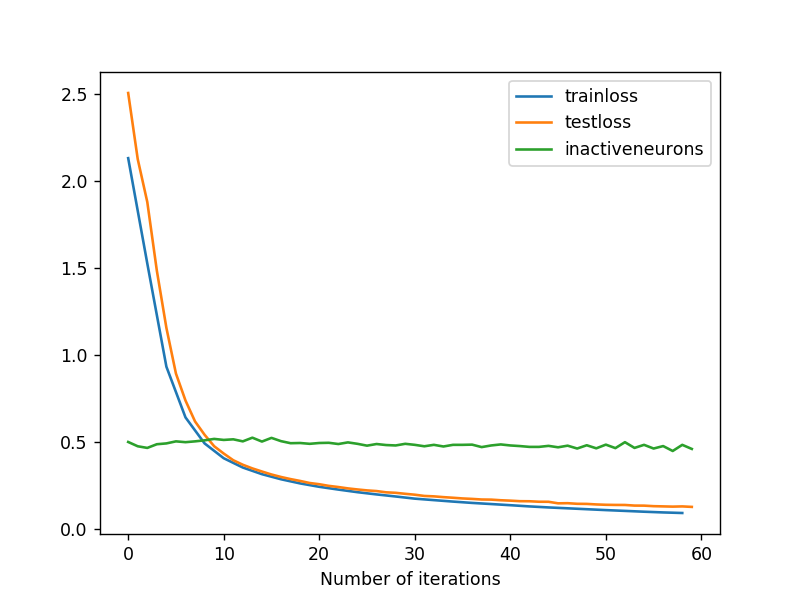

In [80]:
dim=[784,500,250,100,10]
activation=['sigmoid','sigmoid','sigmoid','linear']
batch_size=64
mlp_sigmoid=MLP(dim,activation,batch_size,0.01,0.0)

epoch_train_loss_list,test_loss_list,inactive_neurons_count_list=train(mlp_sigmoid,training_data,training_label_vector,test_data,test_label_vector,30)
index=np.multiply(2,range(0,len(epoch_train_loss_list)))  
%matplotlib notebook
plt.plot(index,epoch_train_loss_list,label='trainloss')
plt.plot(range(0,len(test_loss_list)),test_loss_list,label='testloss')
plt.plot(range(0,len(test_loss_list)),inactive_neurons_count_list,label='inactiveneurons')
plt.xlabel('Number of iterations')
plt.legend()
plt.show()


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Confusion matrix, without normalization


<IPython.core.display.Javascript object>


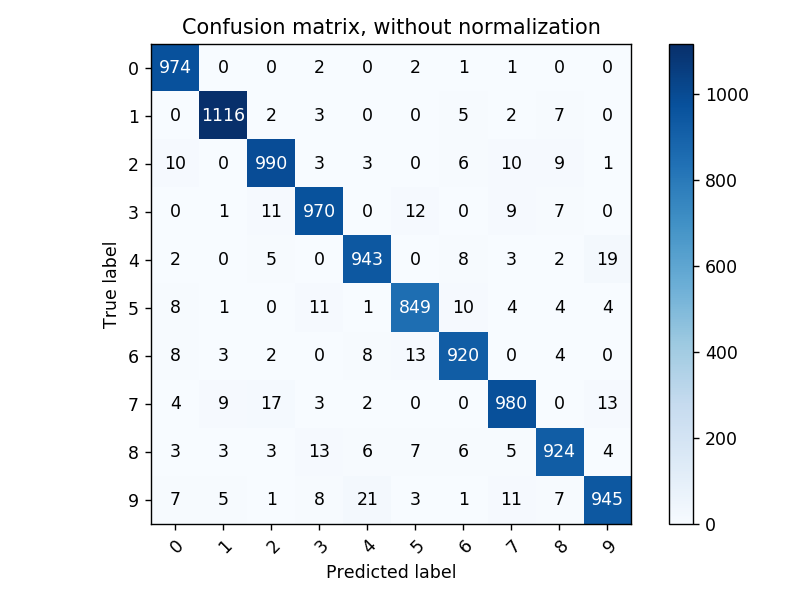

ACCURACY 0.9611
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.96      0.99      0.98       980
         one       0.98      0.98      0.98      1135
         two       0.96      0.96      0.96      1032
       three       0.96      0.96      0.96      1010
        four       0.96      0.96      0.96       982
        five       0.96      0.95      0.96       892
         six       0.96      0.96      0.96       958
       seven       0.96      0.95      0.95      1028
       eight       0.96      0.95      0.95       974
        nine       0.96      0.94      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [81]:
report_classifier_result(mlp_sigmoid,test_data,test_label_vector)

# tanh activation with no regularization

Epoch: 1
3.146419360405675
0.2885765003620576
epoch loss 20067.590779624774
Epoch: 2
0.2522697920076607
0.22470543302058982
epoch loss 13396.611879964772
Epoch: 3
0.20901588920996242
0.19553452247349032
epoch loss 11359.85606463854
Epoch: 4
0.1833664858920463
0.175108700079551
epoch loss 10032.48533064166
Epoch: 5
0.16751906920287332
0.16151993384032012
epoch loss 9057.914954925627
Epoch: 6
0.15671341819213438
0.15131592408711383
epoch loss 8255.640208909606
Epoch: 7
0.14894797233620466
0.1429438973652573
epoch loss 7575.163242707477
Epoch: 8
0.14034243679558206
0.13701105127225388
epoch loss 7041.900563790867
Epoch: 9
0.135705603650454
0.1281858089322067
epoch loss 6574.63276637708
Epoch: 10
0.12964460389499538
0.12478272108451104
epoch loss 6173.43194459455
Epoch: 11
0.1260685817071545
0.12134697050073821
epoch loss 5833.685576169135
Epoch: 12
0.12032973673123508
0.1188489571392123
epoch loss 5482.220241868129
Epoch: 13
0.11649506594792262
0.11707483862683798
epoch loss 5207.82247220

<IPython.core.display.Javascript object>


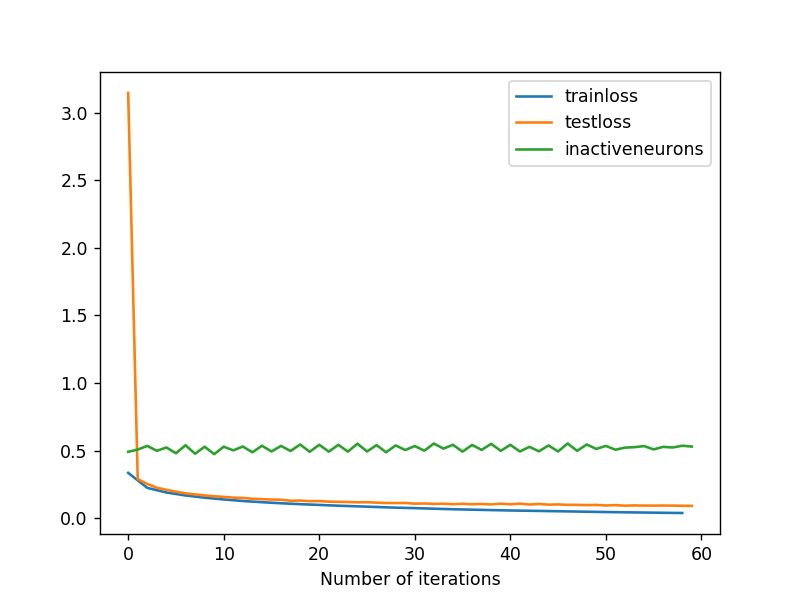

In [83]:
dim=[784,500,250,100,10]
activation=['tanh','tanh','tanh','linear']
batch_size=64
mlp_tanh=MLP(dim,activation,batch_size,0.01,0)
epoch_train_loss_list,test_loss_list,inactive_neurons_count_list=train(mlp_tanh,training_data,training_label_vector,test_data,test_label_vector,30)
index=np.multiply(2,range(0,len(epoch_train_loss_list)))  
%matplotlib notebook
plt.plot(index,epoch_train_loss_list,label='trainloss')
plt.plot(range(0,len(test_loss_list)),test_loss_list,label='testloss')
plt.plot(range(0,len(test_loss_list)),inactive_neurons_count_list,label='inactiveneurons')
plt.xlabel('Number of iterations')
plt.legend()
plt.show()

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


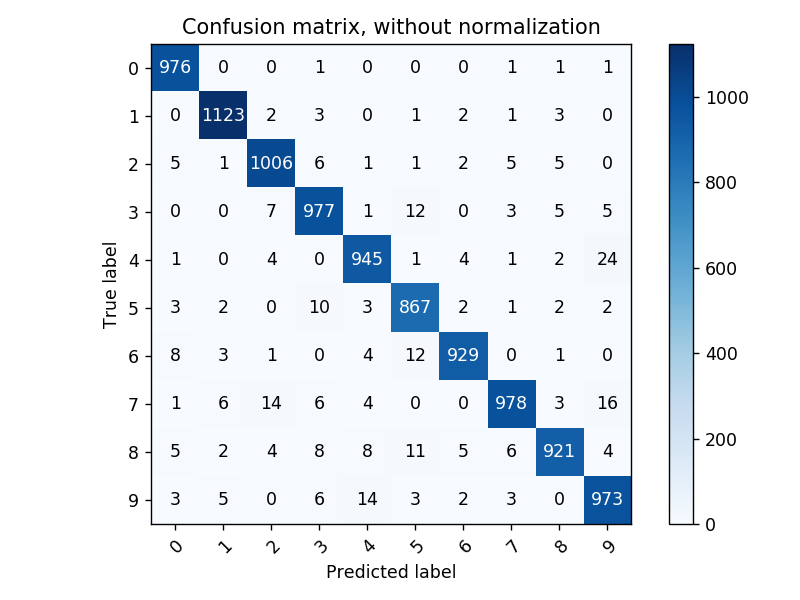

ACCURACY 0.9695
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.97      1.00      0.98       980
         one       0.98      0.99      0.99      1135
         two       0.97      0.97      0.97      1032
       three       0.96      0.97      0.96      1010
        four       0.96      0.96      0.96       982
        five       0.95      0.97      0.96       892
         six       0.98      0.97      0.98       958
       seven       0.98      0.95      0.96      1028
       eight       0.98      0.95      0.96       974
        nine       0.95      0.96      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [84]:
report_classifier_result(mlp_tanh,test_data,test_label_vector)

# Relu Activation with no regularization

 - Not working

Epoch: 1
2.233030864357665
1.8919247936339296
epoch loss 106678.97434313585
Epoch: 2
1.4985212453619496
1.274484550859929
epoch loss 77205.0413815879
Epoch: 3
1.149435627789414
1.0640510980036724
epoch loss 63867.74757452158
Epoch: 4
0.9939709335732912
0.9498674219749397
epoch loss 57205.42198175349
Epoch: 5
0.9053513765539702
0.864950625250321
epoch loss 52265.79767756183
Epoch: 6
0.8247671090179408
0.8057531086176678
epoch loss 48808.59539554706
Epoch: 7
0.7761461921163669
0.7576768938984714
epoch loss 46274.78978745958
Epoch: 8
0.7339867371052603
0.7165040357133863
epoch loss 43974.80449131723
Epoch: 9
0.6998259903735651
0.6925686498940736
epoch loss 42336.10180419389
Epoch: 10
0.6708723231007271
0.6524193496394287
epoch loss 40273.883829405815
Epoch: 11
0.6406380527743993
0.6260028306835538
epoch loss 38639.210501916474
Epoch: 12
0.6130632550517904
0.605094552343481
epoch loss 37469.375564331276
Epoch: 13
0.5973061100903652
0.5874994886581624
epoch loss 36594.64919595517
Epoch: 14


<IPython.core.display.Javascript object>


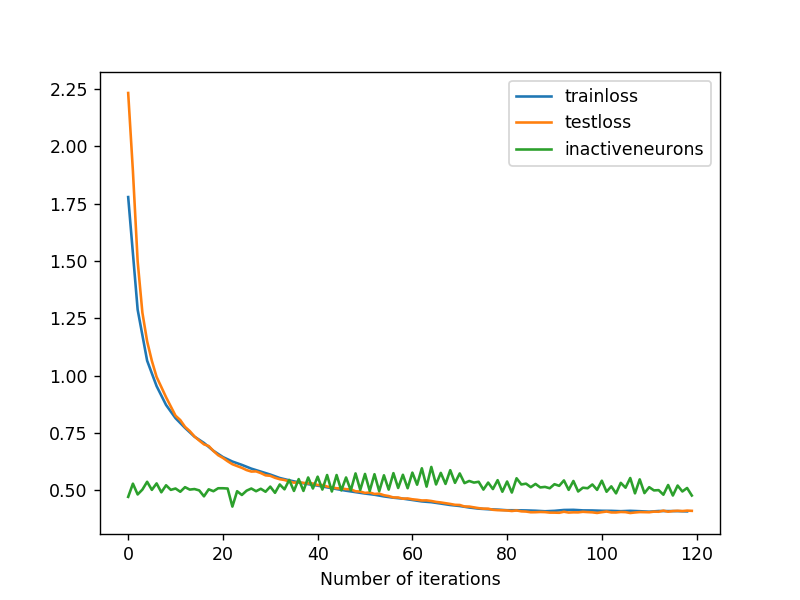

In [87]:
dim=[784,500,250,100,10]
activation=['relu','relu','relu','linear']
batch_size=64
mlp_relu=MLP(dim,activation,batch_size,0.01,0.0)

epoch_train_loss_list,test_loss_list,inactive_neurons_count_list=train(mlp_relu,training_data,training_label_vector,test_data,test_label_vector,60)
index=np.multiply(2,range(0,len(epoch_train_loss_list)))  
%matplotlib notebook
plt.plot(index,epoch_train_loss_list,label='trainloss')
plt.plot(range(0,len(test_loss_list)),test_loss_list,label='testloss')
plt.plot(range(0,len(test_loss_list)),inactive_neurons_count_list,label='inactiveneurons')
plt.xlabel('Number of iterations')
plt.legend()
plt.show()

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


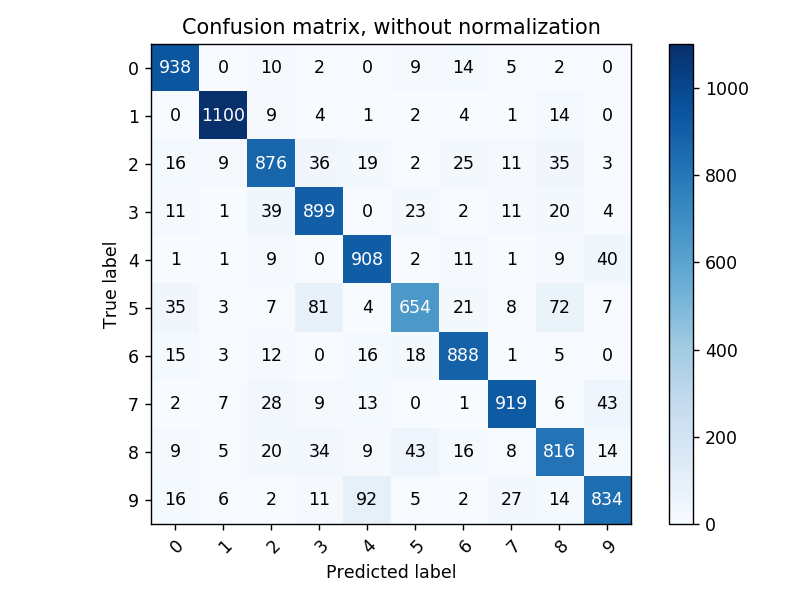

ACCURACY 0.8832
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.90      0.96      0.93       980
         one       0.97      0.97      0.97      1135
         two       0.87      0.85      0.86      1032
       three       0.84      0.89      0.86      1010
        four       0.85      0.92      0.89       982
        five       0.86      0.73      0.79       892
         six       0.90      0.93      0.91       958
       seven       0.93      0.89      0.91      1028
       eight       0.82      0.84      0.83       974
        nine       0.88      0.83      0.85      1009

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [88]:
report_classifier_result(mlp_relu,test_data,test_label_vector)

# Sigmoid Activation with L2 Regularization

Epoch: 1
2.6974454137908377
2.1378706185811582
epoch loss 179400.42348695928
Epoch: 2
1.9046112941483344
1.5174639921307083
epoch loss 143481.1015319191
Epoch: 3
1.2017874020255175
0.958255073476858
epoch loss 109513.19986225247
Epoch: 4
0.8087874420602228
0.682661190312666
epoch loss 92125.23071059101
Epoch: 5
0.5983079166463282
0.5262476926374036
epoch loss 82007.97795604919
Epoch: 6
0.478100650882819
0.4351539137145501
epoch loss 75704.15673603836
Epoch: 7
0.4073358170514939
0.379754039180835
epoch loss 71495.39907454619
Epoch: 8
0.3611505492099666
0.3427122778162995
epoch loss 68300.10558531548
Epoch: 9
0.32925454469850707
0.31708012879947195
epoch loss 65670.41709475919
Epoch: 10
0.3061614581250252
0.2959043217488702
epoch loss 63406.6254303007
Epoch: 11
0.28769446286701444
0.27810172229015423
epoch loss 61384.069920586
Epoch: 12
0.27061709080724644
0.2646694182811252
epoch loss 59617.33169494383
Epoch: 13
0.2571428492700318
0.2518016621498145
epoch loss 57881.43245919366
Epoch: 1

<IPython.core.display.Javascript object>


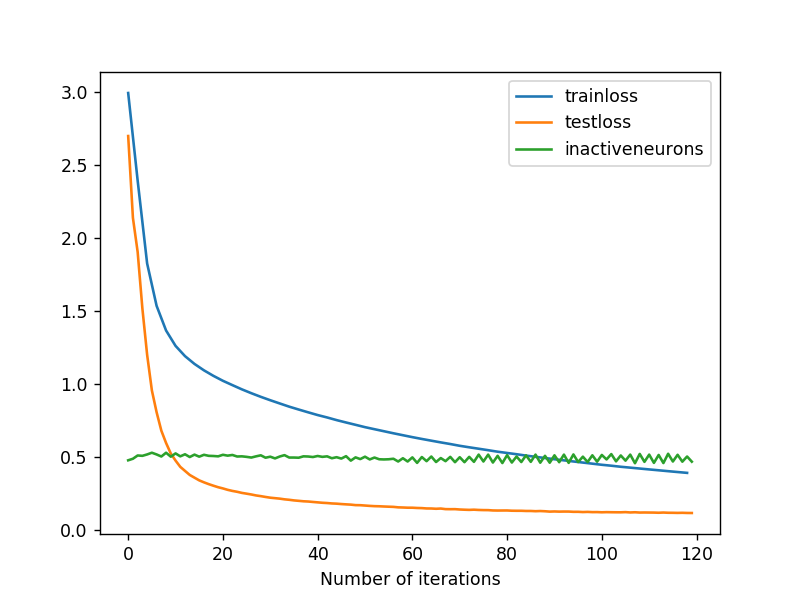

In [91]:
dim=[784,500,250,100,10]
activation=['sigmoid','sigmoid','sigmoid','linear']
batch_size=64
mlp_sigmoid_l2=MLP(dim,activation,batch_size,0.01,0.1)

epoch_train_loss_list,test_loss_list,inactive_neurons_count_list=train(mlp_sigmoid_l2,training_data,training_label_vector,test_data,test_label_vector,60)
index=np.multiply(2,range(0,len(epoch_train_loss_list)))  
%matplotlib notebook
plt.plot(index,epoch_train_loss_list,label='trainloss')
plt.plot(range(0,len(test_loss_list)),test_loss_list,label='testloss')
plt.plot(range(0,len(test_loss_list)),inactive_neurons_count_list,label='inactiveneurons')
plt.xlabel('Number of iterations')
plt.legend()
plt.show()

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


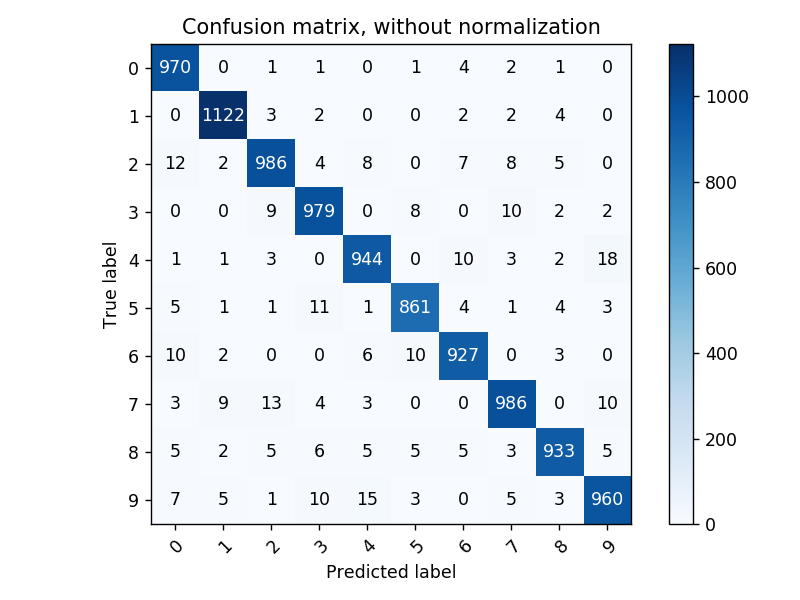

ACCURACY 0.9668
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.96      0.99      0.97       980
         one       0.98      0.99      0.98      1135
         two       0.96      0.96      0.96      1032
       three       0.96      0.97      0.97      1010
        four       0.96      0.96      0.96       982
        five       0.97      0.97      0.97       892
         six       0.97      0.97      0.97       958
       seven       0.97      0.96      0.96      1028
       eight       0.97      0.96      0.97       974
        nine       0.96      0.95      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [92]:
report_classifier_result(mlp_sigmoid_l2,test_data,test_label_vector)

# HOG Feature Extraction

In [32]:
training_data_hog=np.zeros((36,60000))
test_data_hog=np.zeros((36,10000))


for i in range(0,60000):
    training_data_hog[:,i] = hog(training_data[:,i].reshape(28,28), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)

    
for i in range(0,10000):
    test_data_hog[:,i] = hog(test_data[:,i].reshape(28,28), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)


# SVM Classifier on extracted HOG Features

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


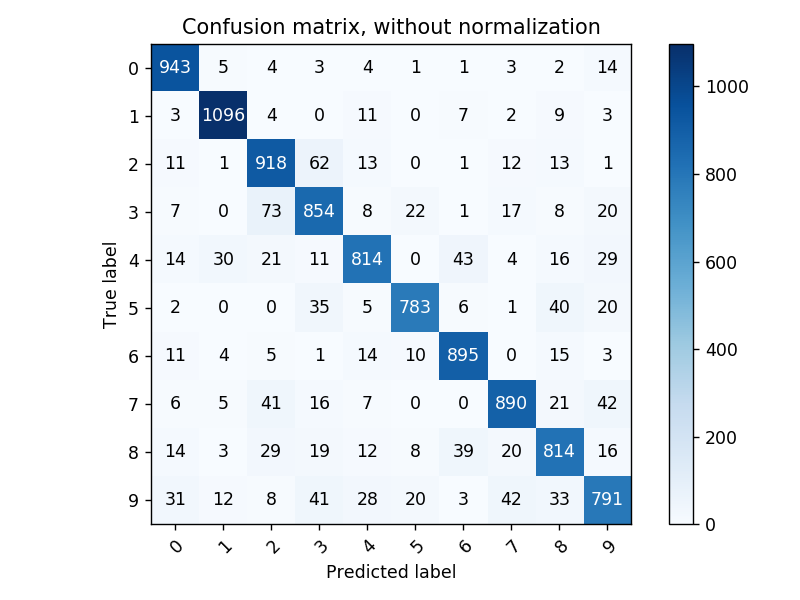

ACCURACY 0.8798
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.90      0.96      0.93       980
         one       0.95      0.97      0.96      1135
         two       0.83      0.89      0.86      1032
       three       0.82      0.85      0.83      1010
        four       0.89      0.83      0.86       982
        five       0.93      0.88      0.90       892
         six       0.90      0.93      0.92       958
       seven       0.90      0.87      0.88      1028
       eight       0.84      0.84      0.84       974
        nine       0.84      0.78      0.81      1009

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [41]:
clf = LinearSVC()
clf.fit(np.transpose(training_data_hog),training_label)
test_pred_svc=clf.predict(np.transpose(test_data_hog))
reporter_clf(test_label, test_pred_svc)

# kNN Classifier on Extracted HOG Features (k=9)

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


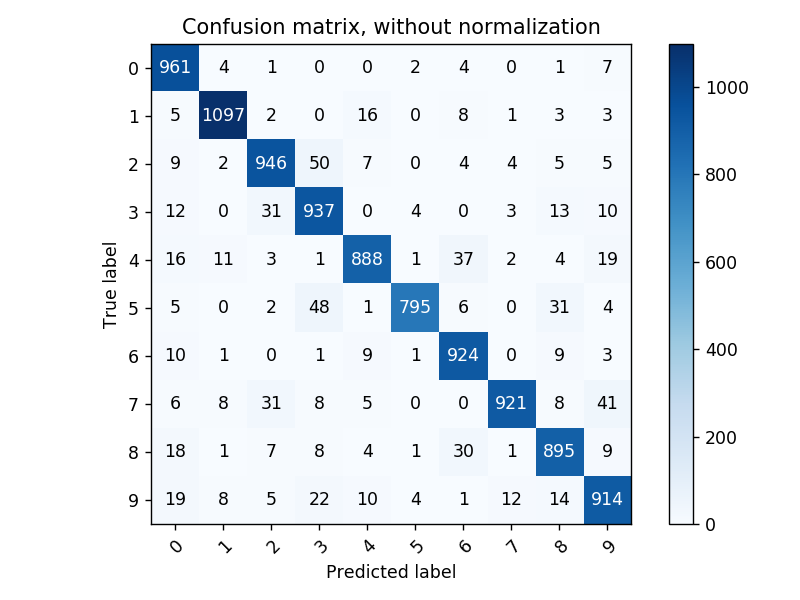

ACCURACY 0.9278
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.91      0.98      0.94       980
         one       0.97      0.97      0.97      1135
         two       0.92      0.92      0.92      1032
       three       0.87      0.93      0.90      1010
        four       0.94      0.90      0.92       982
        five       0.98      0.89      0.94       892
         six       0.91      0.96      0.94       958
       seven       0.98      0.90      0.93      1028
       eight       0.91      0.92      0.91       974
        nine       0.90      0.91      0.90      1009

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [40]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=9)
model.fit(np.transpose(training_data_hog), training_label)
test_pred_knn9 = model.predict(np.transpose(test_data_hog))
reporter_clf(test_label, test_pred_knn9)

# MLP on extracted HOG features

Epoch: 1
2.2796628730982085
0.6182910455465415
epoch loss 55184.57516990422
Epoch: 2
0.47761527684105404
0.4066134833689969
epoch loss 28591.49133835872
Epoch: 3
0.39897690398838204
0.3728698007754455
epoch loss 26204.418612178586
Epoch: 4
0.3721939701912875
0.3580350878180219
epoch loss 25122.894661611746
Epoch: 5
0.3572064553778488
0.34773475424317796
epoch loss 24372.546006219643
Epoch: 6
0.3459748802860095
0.33885817539681656
epoch loss 23742.507882388374
Epoch: 7
0.3362151077576571
0.33058606257873946
epoch loss 23166.997123676352
Epoch: 8
0.3271831658649248
0.32272525880691927
epoch loss 22621.69178110007
Epoch: 9
0.3185425716505962
0.31504799706093517
epoch loss 22088.437037344807
Epoch: 10
0.30996106628057835
0.3071947661205212
epoch loss 21547.17155553907
Epoch: 11
0.30115721095513803
0.2990036600328543
epoch loss 20989.901140076563
Epoch: 12
0.2922153162066786
0.29078266731660446
epoch loss 20435.219773980905
Epoch: 13
0.2838048725205082
0.2831433758579466
epoch loss 19918.43

<IPython.core.display.Javascript object>


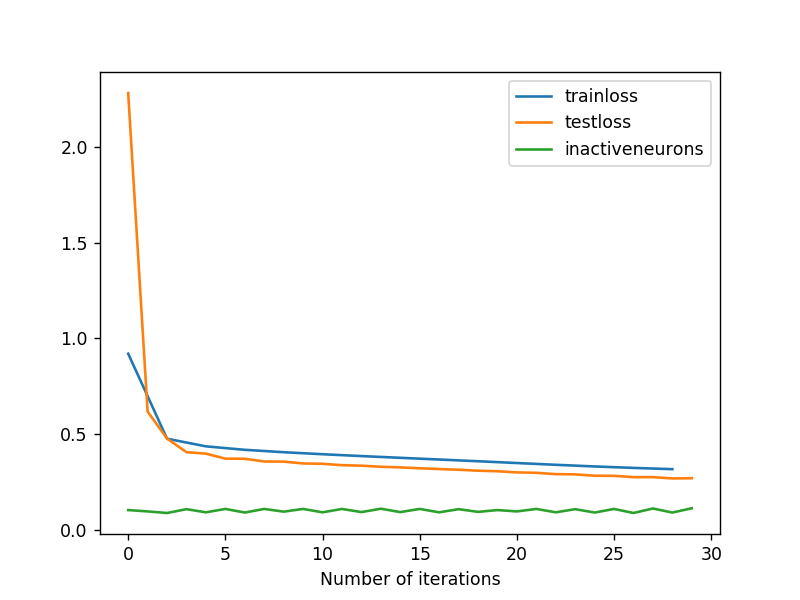

In [34]:
dim=[36,100,50,25,10]
activation=['tanh','tanh','tanh','linear']
batch_size=64
mlp_tanh_hog=MLP(dim,activation,batch_size,0.05,0.01)
epoch_train_loss_list,test_loss_list,inactive_neurons_count_list=train(mlp_tanh_hog,training_data_hog,training_label_vector,test_data_hog,test_label_vector,15)
index=np.multiply(2,range(0,len(epoch_train_loss_list)))  
%matplotlib notebook
plt.plot(index,epoch_train_loss_list,label='trainloss')
plt.plot(range(0,len(test_loss_list)),test_loss_list,label='testloss')
plt.plot(range(0,len(test_loss_list)),inactive_neurons_count_list,label='inactiveneurons')
plt.xlabel('Number of iterations')
plt.legend()
plt.show()

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


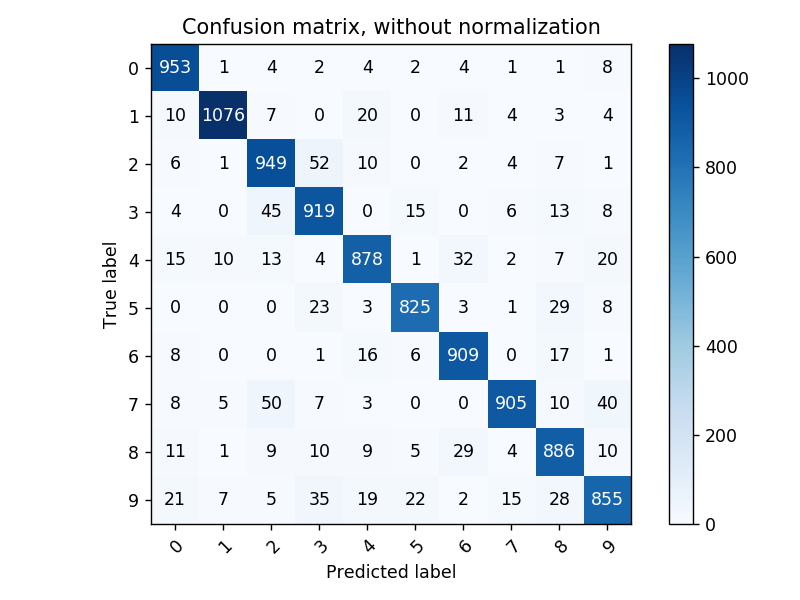

ACCURACY 0.9155
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.92      0.97      0.95       980
         one       0.98      0.95      0.96      1135
         two       0.88      0.92      0.90      1032
       three       0.87      0.91      0.89      1010
        four       0.91      0.89      0.90       982
        five       0.94      0.92      0.93       892
         six       0.92      0.95      0.93       958
       seven       0.96      0.88      0.92      1028
       eight       0.89      0.91      0.90       974
        nine       0.90      0.85      0.87      1009

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [35]:
report_classifier_result(mlp_tanh_hog,test_data_hog,test_label_vector)

# General Inferences

 - Vectorized Codes run faster
 - Softmax normalization technique incorporated for numerical stability
 - Loss Function Slightly clipped for numerical stability
 

# Results without feature extraction

Architecture:
 - dim=[784,500,250,100,10]
 - activation=['sigmoid','sigmoid','sigmoid','linear']
 - batch_size=64

| Activation | Learning Rate | Regularization | Epochs | Accuracy |
| --- | --- | --- | --- | --- |
| Sigmoid |0.01| No | 30 | 96.11%
| tanh |0.01| No | 30 | 96.95%
| Relu |0.01| No | 30 | 88.32%
| Sigmoid |0.01| L2 0.1 | 60 | 96.68%

# Results on HOG Feature

MLP Architecture:
 - dim=[36,100,50,25,10]
 - activation=['tanh','tanh','tanh','linear']
 - batch_size=64

| Model | Learning Rate | Regularization | Epochs | Accuracy |
| --- | --- | --- | --- | --- |
| kNN |NA| NA | NA | 87.98%
| Linear SVM |NA| NA | NA | 92.78%
| tanh |0.05| L2 0.1 | 15 | 91.55%

# Inferences

 - MLP with tanh activation converges the fastest
 - MLP with L2 regularization is more accurate than MLP without L2 regularization (see Results)
 - Adding gaussian noise in the forward/backward pass didn't help as much as L2 regularization
 - KNN and linear SVM on HOG features were less accurate than MLP on original image
 - MLP on extracted feature was comparable to KNN and linear SVM but not quite close to MLP on original data in terms of accuracy 

 - The fraction of inactive neurons was close to 0.5 and didn't change much with epochs for the given architecture regardless of the activation
 - This maybe due to the network not being too deep for the classification problem at hand
 - On the other hand, the fraction of inactive neurons was around 0.1 for the MLP used on HOG features, meaning the network wasn't deep enough(?)

Epoch: 1
2.293815899920105
0.48280189470473367
epoch loss 48752.41713729225
Epoch: 2
0.4247216641433982
0.3775763161576913
epoch loss 28544.12737762935
Epoch: 3
0.3769396079306141
0.3576502199094215
epoch loss 27021.023027209507
Epoch: 4
0.3579752669919345
0.34732214692297275
epoch loss 26217.93519159192
Epoch: 5
0.34589948269255966
0.3399020863482891
epoch loss 25617.094415140215
Epoch: 6
0.3365561423372849
0.33362402964238325
epoch loss 25103.51977836984
Epoch: 7
0.32851560431788246
0.32760049795466295
epoch loss 24624.02384815778
Epoch: 8
0.3209149684038103
0.3212246390619481
epoch loss 24138.201690156435
Epoch: 9
0.31307332337752886
0.31396231284923176
epoch loss 23608.53405713821
Epoch: 10
0.30445145472165014
0.30539795072339215
epoch loss 23007.891021166826
Epoch: 11
0.2948791038095166
0.2956342344016115
epoch loss 22344.024869996912
Epoch: 12
0.2847867521926812
0.2855054755109317
epoch loss 21667.95950733501
Epoch: 13
0.2750001948762451
0.27603875335273026
epoch loss 21039.22338

<IPython.core.display.Javascript object>


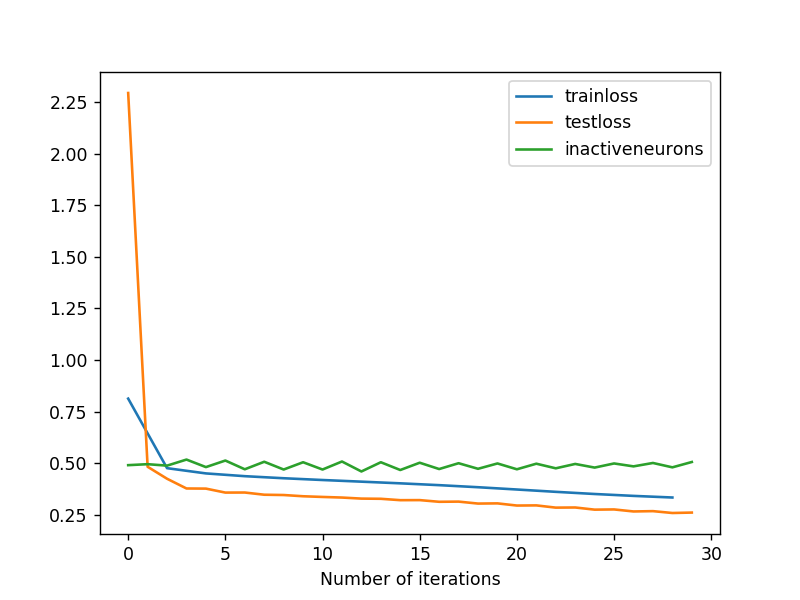

In [38]:
dim=[36,500,250,100,10]
activation=['tanh','tanh','tanh','linear']
batch_size=64
mlp_tanh_hog=MLP(dim,activation,batch_size,0.05,0.01)
epoch_train_loss_list,test_loss_list,inactive_neurons_count_list=train(mlp_tanh_hog,training_data_hog,training_label_vector,test_data_hog,test_label_vector,15)
index=np.multiply(2,range(0,len(epoch_train_loss_list)))  
%matplotlib notebook
plt.plot(index,epoch_train_loss_list,label='trainloss')
plt.plot(range(0,len(test_loss_list)),test_loss_list,label='testloss')
plt.plot(range(0,len(test_loss_list)),inactive_neurons_count_list,label='inactiveneurons')
plt.xlabel('Number of iterations')
plt.legend()
plt.show()

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


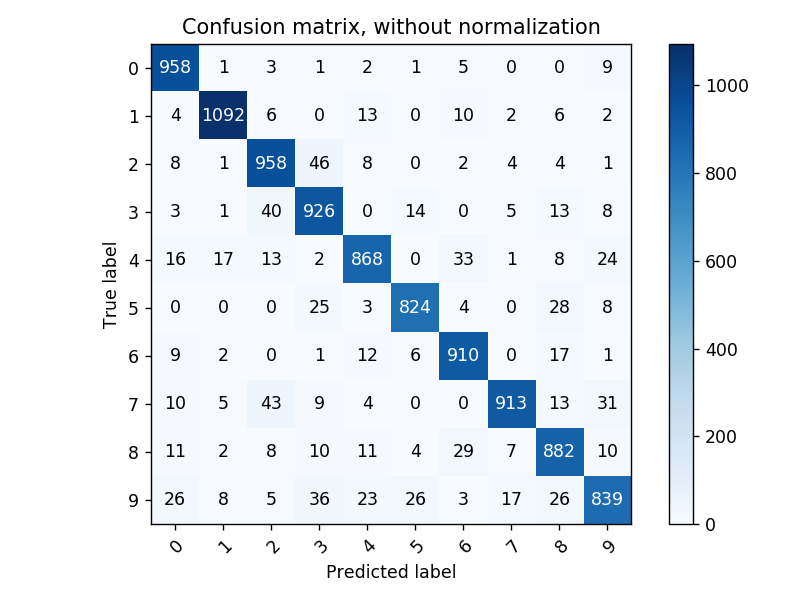

ACCURACY 0.917
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        zero       0.92      0.98      0.95       980
         one       0.97      0.96      0.96      1135
         two       0.89      0.93      0.91      1032
       three       0.88      0.92      0.90      1010
        four       0.92      0.88      0.90       982
        five       0.94      0.92      0.93       892
         six       0.91      0.95      0.93       958
       seven       0.96      0.89      0.92      1028
       eight       0.88      0.91      0.89       974
        nine       0.90      0.83      0.86      1009

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [39]:
report_classifier_result(mlp_tanh_hog,test_data_hog,test_label_vector)

# Making it a deeper network didn't help much!

# Concluding Remarks

 - While implementing, I had to care about various overflows and numerical instabilities
 - Surprising that MLP could do so well without any traditional CV feature extraction techniques.
 - Let's see how well CNN does!